# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


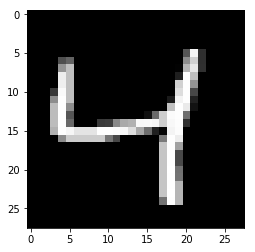

In [3]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

In [4]:
mnist.train.images.shape

(60000, 784)

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by a factor of 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

In [13]:
learning_rate = 0.001
# Input and target placeholders
inputs_ = tf.placeholder(tf.float32, [None, 28, 28, 1])
targets_ = tf.placeholder(tf.float32, [None, 28, 28, 1])

### Encoder
conv1 = tf.layers.conv2d(inputs_, 16, 3, strides=1, padding='same')
print('conv1.shape (should be 28x28x16)', conv1.shape)
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(conv1, 2, 2, padding='valid')
print('maxpool1.shape (should be 14x14x16)', maxpool1.shape)
# Now 14x14x16
conv2 = tf.layers.conv2d(maxpool1, 8, 3, strides=1, padding='same')
print('conv2.shape (should be 14x14x8)', conv2.shape)
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(conv2, 2, 2, padding='valid')
print('maxpool2.shape (should be 7x7x8)', maxpool2.shape)
# Now 7x7x8
conv3 = tf.layers.conv2d(maxpool2, 8, 3, strides=1, padding='same')
print('conv3.shape (should be 7x7x8)', conv3.shape)
# Now 7x7x8
encoded = tf.layers.max_pooling2d(conv3, 2, 2, padding='same')
print('encoded.shape (should be 4x4x8)', encoded.shape)
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_images(encoded, [7, 7])
print('upsample1.shape (should be 7x7x8)', upsample1.shape)
# Now 7x7x8
conv4 = tf.layers.conv2d(upsample1, 8, 3, strides=1, padding='same')
print('conv4.shape (should be 7x7x8)', conv4.shape)
# Now 7x7x8
upsample2 = tf.image.resize_images(conv4, [14, 14])
print('upsample2.shape (should be 14x14x8)', upsample2.shape)
# Now 14x14x8
conv5 = tf.layers.conv2d(upsample2, 8, 3, strides=1, padding='same')
print('conv5.shape (should be 14x14x8)', conv5.shape)
# Now 14x14x8
upsample3 = tf.image.resize_images(conv5, [28, 28])
print('upsample3.shape (should be 28x28x8)', upsample3.shape)
# Now 28x28x8
conv6 = tf.layers.conv2d(upsample3, 16, 3, strides=1, padding='same')
print('conv6.shape (should be 28x28x16)', conv6.shape)
# Now 28x28x16

logits = tf.layers.conv2d(conv6, 1, 3, strides=1, padding='same')
print('logits.shape (should be 28x28x1)', logits.shape)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

conv1.shape (should be 28x28x16) (?, 28, 28, 16)
maxpool1.shape (should be 14x14x16) (?, 14, 14, 16)
conv2.shape (should be 14x14x8) (?, 14, 14, 8)
maxpool2.shape (should be 7x7x8) (?, 7, 7, 8)
conv3.shape (should be 7x7x8) (?, 7, 7, 8)
encoded.shape (should be 4x4x8) (?, 4, 4, 8)
upsample1.shape (should be 7x7x8) (?, 7, 7, 8)
conv4.shape (should be 7x7x8) (?, 7, 7, 8)
upsample2.shape (should be 14x14x8) (?, 14, 14, 8)
conv5.shape (should be 14x14x8) (?, 14, 14, 8)
upsample3.shape (should be 28x28x8) (?, 28, 28, 8)
conv6.shape (should be 28x28x16) (?, 28, 28, 16)
logits.shape (should be 28x28x1) (?, 28, 28, 1)


## Training

As before, here we'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [15]:
sess = tf.Session()

In [16]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.6986
Epoch: 1/20... Training loss: 0.6748
Epoch: 1/20... Training loss: 0.6515
Epoch: 1/20... Training loss: 0.6268
Epoch: 1/20... Training loss: 0.5989
Epoch: 1/20... Training loss: 0.5742
Epoch: 1/20... Training loss: 0.5547
Epoch: 1/20... Training loss: 0.5423
Epoch: 1/20... Training loss: 0.5540
Epoch: 1/20... Training loss: 0.5583
Epoch: 1/20... Training loss: 0.5405
Epoch: 1/20... Training loss: 0.5496
Epoch: 1/20... Training loss: 0.5140
Epoch: 1/20... Training loss: 0.5108
Epoch: 1/20... Training loss: 0.4997
Epoch: 1/20... Training loss: 0.4985
Epoch: 1/20... Training loss: 0.4837
Epoch: 1/20... Training loss: 0.4880
Epoch: 1/20... Training loss: 0.4775
Epoch: 1/20... Training loss: 0.4674
Epoch: 1/20... Training loss: 0.4621
Epoch: 1/20... Training loss: 0.4502
Epoch: 1/20... Training loss: 0.4415
Epoch: 1/20... Training loss: 0.4330
Epoch: 1/20... Training loss: 0.4240
Epoch: 1/20... Training loss: 0.4125
Epoch: 1/20... Training loss: 0.3975
E

Epoch: 1/20... Training loss: 0.1946
Epoch: 1/20... Training loss: 0.1929
Epoch: 1/20... Training loss: 0.1945
Epoch: 1/20... Training loss: 0.1891
Epoch: 1/20... Training loss: 0.1906
Epoch: 1/20... Training loss: 0.2009
Epoch: 1/20... Training loss: 0.1948
Epoch: 1/20... Training loss: 0.1876
Epoch: 1/20... Training loss: 0.1962
Epoch: 1/20... Training loss: 0.1907
Epoch: 1/20... Training loss: 0.1850
Epoch: 1/20... Training loss: 0.1959
Epoch: 1/20... Training loss: 0.1925
Epoch: 1/20... Training loss: 0.1920
Epoch: 1/20... Training loss: 0.1958
Epoch: 1/20... Training loss: 0.1930
Epoch: 1/20... Training loss: 0.1936
Epoch: 1/20... Training loss: 0.1951
Epoch: 1/20... Training loss: 0.1937
Epoch: 1/20... Training loss: 0.1971
Epoch: 1/20... Training loss: 0.1921
Epoch: 1/20... Training loss: 0.1908
Epoch: 1/20... Training loss: 0.1905
Epoch: 1/20... Training loss: 0.1886
Epoch: 1/20... Training loss: 0.1975
Epoch: 1/20... Training loss: 0.1925
Epoch: 1/20... Training loss: 0.1905
E

Epoch: 2/20... Training loss: 0.1775
Epoch: 2/20... Training loss: 0.1722
Epoch: 2/20... Training loss: 0.1783
Epoch: 2/20... Training loss: 0.1768
Epoch: 2/20... Training loss: 0.1780
Epoch: 2/20... Training loss: 0.1772
Epoch: 2/20... Training loss: 0.1716
Epoch: 2/20... Training loss: 0.1833
Epoch: 2/20... Training loss: 0.1733
Epoch: 2/20... Training loss: 0.1764
Epoch: 2/20... Training loss: 0.1780
Epoch: 2/20... Training loss: 0.1772
Epoch: 2/20... Training loss: 0.1722
Epoch: 2/20... Training loss: 0.1758
Epoch: 2/20... Training loss: 0.1762
Epoch: 2/20... Training loss: 0.1801
Epoch: 2/20... Training loss: 0.1711
Epoch: 2/20... Training loss: 0.1764
Epoch: 2/20... Training loss: 0.1827
Epoch: 2/20... Training loss: 0.1733
Epoch: 2/20... Training loss: 0.1736
Epoch: 2/20... Training loss: 0.1767
Epoch: 2/20... Training loss: 0.1727
Epoch: 2/20... Training loss: 0.1778
Epoch: 2/20... Training loss: 0.1770
Epoch: 2/20... Training loss: 0.1848
Epoch: 2/20... Training loss: 0.1729
E

Epoch: 3/20... Training loss: 0.1722
Epoch: 3/20... Training loss: 0.1650
Epoch: 3/20... Training loss: 0.1727
Epoch: 3/20... Training loss: 0.1733
Epoch: 3/20... Training loss: 0.1707
Epoch: 3/20... Training loss: 0.1719
Epoch: 3/20... Training loss: 0.1651
Epoch: 3/20... Training loss: 0.1705
Epoch: 3/20... Training loss: 0.1666
Epoch: 3/20... Training loss: 0.1586
Epoch: 3/20... Training loss: 0.1668
Epoch: 3/20... Training loss: 0.1661
Epoch: 3/20... Training loss: 0.1714
Epoch: 3/20... Training loss: 0.1702
Epoch: 3/20... Training loss: 0.1676
Epoch: 3/20... Training loss: 0.1672
Epoch: 3/20... Training loss: 0.1648
Epoch: 3/20... Training loss: 0.1682
Epoch: 3/20... Training loss: 0.1721
Epoch: 3/20... Training loss: 0.1646
Epoch: 3/20... Training loss: 0.1701
Epoch: 3/20... Training loss: 0.1711
Epoch: 3/20... Training loss: 0.1672
Epoch: 3/20... Training loss: 0.1696
Epoch: 3/20... Training loss: 0.1674
Epoch: 3/20... Training loss: 0.1641
Epoch: 3/20... Training loss: 0.1712
E

Epoch: 3/20... Training loss: 0.1627
Epoch: 3/20... Training loss: 0.1649
Epoch: 3/20... Training loss: 0.1637
Epoch: 3/20... Training loss: 0.1681
Epoch: 3/20... Training loss: 0.1565
Epoch: 3/20... Training loss: 0.1643
Epoch: 3/20... Training loss: 0.1649
Epoch: 3/20... Training loss: 0.1657
Epoch: 3/20... Training loss: 0.1553
Epoch: 3/20... Training loss: 0.1630
Epoch: 3/20... Training loss: 0.1650
Epoch: 3/20... Training loss: 0.1596
Epoch: 4/20... Training loss: 0.1619
Epoch: 4/20... Training loss: 0.1638
Epoch: 4/20... Training loss: 0.1654
Epoch: 4/20... Training loss: 0.1614
Epoch: 4/20... Training loss: 0.1627
Epoch: 4/20... Training loss: 0.1592
Epoch: 4/20... Training loss: 0.1657
Epoch: 4/20... Training loss: 0.1671
Epoch: 4/20... Training loss: 0.1669
Epoch: 4/20... Training loss: 0.1700
Epoch: 4/20... Training loss: 0.1571
Epoch: 4/20... Training loss: 0.1603
Epoch: 4/20... Training loss: 0.1641
Epoch: 4/20... Training loss: 0.1647
Epoch: 4/20... Training loss: 0.1638
E

Epoch: 4/20... Training loss: 0.1611
Epoch: 4/20... Training loss: 0.1605
Epoch: 4/20... Training loss: 0.1671
Epoch: 4/20... Training loss: 0.1627
Epoch: 4/20... Training loss: 0.1564
Epoch: 4/20... Training loss: 0.1563
Epoch: 4/20... Training loss: 0.1604
Epoch: 4/20... Training loss: 0.1575
Epoch: 4/20... Training loss: 0.1622
Epoch: 4/20... Training loss: 0.1535
Epoch: 4/20... Training loss: 0.1636
Epoch: 4/20... Training loss: 0.1640
Epoch: 4/20... Training loss: 0.1641
Epoch: 4/20... Training loss: 0.1619
Epoch: 4/20... Training loss: 0.1634
Epoch: 4/20... Training loss: 0.1578
Epoch: 4/20... Training loss: 0.1579
Epoch: 4/20... Training loss: 0.1603
Epoch: 4/20... Training loss: 0.1594
Epoch: 4/20... Training loss: 0.1637
Epoch: 4/20... Training loss: 0.1607
Epoch: 4/20... Training loss: 0.1591
Epoch: 4/20... Training loss: 0.1639
Epoch: 4/20... Training loss: 0.1617
Epoch: 4/20... Training loss: 0.1516
Epoch: 4/20... Training loss: 0.1562
Epoch: 4/20... Training loss: 0.1548
E

Epoch: 5/20... Training loss: 0.1574
Epoch: 5/20... Training loss: 0.1543
Epoch: 5/20... Training loss: 0.1583
Epoch: 5/20... Training loss: 0.1550
Epoch: 5/20... Training loss: 0.1582
Epoch: 5/20... Training loss: 0.1533
Epoch: 5/20... Training loss: 0.1596
Epoch: 5/20... Training loss: 0.1567
Epoch: 5/20... Training loss: 0.1577
Epoch: 5/20... Training loss: 0.1592
Epoch: 5/20... Training loss: 0.1552
Epoch: 5/20... Training loss: 0.1601
Epoch: 5/20... Training loss: 0.1567
Epoch: 5/20... Training loss: 0.1600
Epoch: 5/20... Training loss: 0.1561
Epoch: 5/20... Training loss: 0.1587
Epoch: 5/20... Training loss: 0.1567
Epoch: 5/20... Training loss: 0.1563
Epoch: 5/20... Training loss: 0.1553
Epoch: 5/20... Training loss: 0.1603
Epoch: 5/20... Training loss: 0.1577
Epoch: 5/20... Training loss: 0.1533
Epoch: 5/20... Training loss: 0.1568
Epoch: 5/20... Training loss: 0.1535
Epoch: 5/20... Training loss: 0.1573
Epoch: 5/20... Training loss: 0.1578
Epoch: 5/20... Training loss: 0.1605
E

Epoch: 6/20... Training loss: 0.1526
Epoch: 6/20... Training loss: 0.1583
Epoch: 6/20... Training loss: 0.1509
Epoch: 6/20... Training loss: 0.1523
Epoch: 6/20... Training loss: 0.1564
Epoch: 6/20... Training loss: 0.1564
Epoch: 6/20... Training loss: 0.1558
Epoch: 6/20... Training loss: 0.1539
Epoch: 6/20... Training loss: 0.1523
Epoch: 6/20... Training loss: 0.1557
Epoch: 6/20... Training loss: 0.1589
Epoch: 6/20... Training loss: 0.1507
Epoch: 6/20... Training loss: 0.1531
Epoch: 6/20... Training loss: 0.1528
Epoch: 6/20... Training loss: 0.1564
Epoch: 6/20... Training loss: 0.1561
Epoch: 6/20... Training loss: 0.1602
Epoch: 6/20... Training loss: 0.1589
Epoch: 6/20... Training loss: 0.1514
Epoch: 6/20... Training loss: 0.1530
Epoch: 6/20... Training loss: 0.1532
Epoch: 6/20... Training loss: 0.1579
Epoch: 6/20... Training loss: 0.1581
Epoch: 6/20... Training loss: 0.1534
Epoch: 6/20... Training loss: 0.1565
Epoch: 6/20... Training loss: 0.1521
Epoch: 6/20... Training loss: 0.1600
E

Epoch: 6/20... Training loss: 0.1495
Epoch: 6/20... Training loss: 0.1579
Epoch: 6/20... Training loss: 0.1471
Epoch: 6/20... Training loss: 0.1529
Epoch: 6/20... Training loss: 0.1576
Epoch: 6/20... Training loss: 0.1536
Epoch: 6/20... Training loss: 0.1541
Epoch: 6/20... Training loss: 0.1549
Epoch: 6/20... Training loss: 0.1485
Epoch: 6/20... Training loss: 0.1501
Epoch: 6/20... Training loss: 0.1521
Epoch: 6/20... Training loss: 0.1537
Epoch: 6/20... Training loss: 0.1492
Epoch: 6/20... Training loss: 0.1525
Epoch: 6/20... Training loss: 0.1488
Epoch: 6/20... Training loss: 0.1495
Epoch: 6/20... Training loss: 0.1510
Epoch: 6/20... Training loss: 0.1471
Epoch: 6/20... Training loss: 0.1535
Epoch: 6/20... Training loss: 0.1506
Epoch: 6/20... Training loss: 0.1492
Epoch: 6/20... Training loss: 0.1488
Epoch: 6/20... Training loss: 0.1541
Epoch: 6/20... Training loss: 0.1482
Epoch: 7/20... Training loss: 0.1526
Epoch: 7/20... Training loss: 0.1532
Epoch: 7/20... Training loss: 0.1526
E

Epoch: 7/20... Training loss: 0.1524
Epoch: 7/20... Training loss: 0.1481
Epoch: 7/20... Training loss: 0.1496
Epoch: 7/20... Training loss: 0.1536
Epoch: 7/20... Training loss: 0.1534
Epoch: 7/20... Training loss: 0.1470
Epoch: 7/20... Training loss: 0.1531
Epoch: 7/20... Training loss: 0.1522
Epoch: 7/20... Training loss: 0.1505
Epoch: 7/20... Training loss: 0.1454
Epoch: 7/20... Training loss: 0.1509
Epoch: 7/20... Training loss: 0.1564
Epoch: 7/20... Training loss: 0.1515
Epoch: 7/20... Training loss: 0.1518
Epoch: 7/20... Training loss: 0.1502
Epoch: 7/20... Training loss: 0.1532
Epoch: 7/20... Training loss: 0.1513
Epoch: 7/20... Training loss: 0.1468
Epoch: 7/20... Training loss: 0.1508
Epoch: 7/20... Training loss: 0.1503
Epoch: 7/20... Training loss: 0.1561
Epoch: 7/20... Training loss: 0.1488
Epoch: 7/20... Training loss: 0.1519
Epoch: 7/20... Training loss: 0.1530
Epoch: 7/20... Training loss: 0.1511
Epoch: 7/20... Training loss: 0.1531
Epoch: 7/20... Training loss: 0.1470
E

Epoch: 8/20... Training loss: 0.1544
Epoch: 8/20... Training loss: 0.1505
Epoch: 8/20... Training loss: 0.1484
Epoch: 8/20... Training loss: 0.1533
Epoch: 8/20... Training loss: 0.1550
Epoch: 8/20... Training loss: 0.1492
Epoch: 8/20... Training loss: 0.1525
Epoch: 8/20... Training loss: 0.1478
Epoch: 8/20... Training loss: 0.1444
Epoch: 8/20... Training loss: 0.1465
Epoch: 8/20... Training loss: 0.1463
Epoch: 8/20... Training loss: 0.1489
Epoch: 8/20... Training loss: 0.1453
Epoch: 8/20... Training loss: 0.1504
Epoch: 8/20... Training loss: 0.1468
Epoch: 8/20... Training loss: 0.1526
Epoch: 8/20... Training loss: 0.1456
Epoch: 8/20... Training loss: 0.1481
Epoch: 8/20... Training loss: 0.1527
Epoch: 8/20... Training loss: 0.1476
Epoch: 8/20... Training loss: 0.1472
Epoch: 8/20... Training loss: 0.1486
Epoch: 8/20... Training loss: 0.1427
Epoch: 8/20... Training loss: 0.1492
Epoch: 8/20... Training loss: 0.1474
Epoch: 8/20... Training loss: 0.1425
Epoch: 8/20... Training loss: 0.1542
E

Epoch: 9/20... Training loss: 0.1498
Epoch: 9/20... Training loss: 0.1506
Epoch: 9/20... Training loss: 0.1501
Epoch: 9/20... Training loss: 0.1491
Epoch: 9/20... Training loss: 0.1445
Epoch: 9/20... Training loss: 0.1488
Epoch: 9/20... Training loss: 0.1438
Epoch: 9/20... Training loss: 0.1509
Epoch: 9/20... Training loss: 0.1451
Epoch: 9/20... Training loss: 0.1473
Epoch: 9/20... Training loss: 0.1473
Epoch: 9/20... Training loss: 0.1448
Epoch: 9/20... Training loss: 0.1539
Epoch: 9/20... Training loss: 0.1446
Epoch: 9/20... Training loss: 0.1505
Epoch: 9/20... Training loss: 0.1475
Epoch: 9/20... Training loss: 0.1441
Epoch: 9/20... Training loss: 0.1497
Epoch: 9/20... Training loss: 0.1532
Epoch: 9/20... Training loss: 0.1440
Epoch: 9/20... Training loss: 0.1441
Epoch: 9/20... Training loss: 0.1441
Epoch: 9/20... Training loss: 0.1509
Epoch: 9/20... Training loss: 0.1495
Epoch: 9/20... Training loss: 0.1455
Epoch: 9/20... Training loss: 0.1482
Epoch: 9/20... Training loss: 0.1461
E

Epoch: 9/20... Training loss: 0.1480
Epoch: 9/20... Training loss: 0.1451
Epoch: 9/20... Training loss: 0.1454
Epoch: 9/20... Training loss: 0.1471
Epoch: 9/20... Training loss: 0.1433
Epoch: 9/20... Training loss: 0.1444
Epoch: 9/20... Training loss: 0.1446
Epoch: 9/20... Training loss: 0.1406
Epoch: 9/20... Training loss: 0.1431
Epoch: 9/20... Training loss: 0.1470
Epoch: 9/20... Training loss: 0.1432
Epoch: 9/20... Training loss: 0.1480
Epoch: 9/20... Training loss: 0.1457
Epoch: 9/20... Training loss: 0.1444
Epoch: 9/20... Training loss: 0.1426
Epoch: 9/20... Training loss: 0.1482
Epoch: 9/20... Training loss: 0.1470
Epoch: 9/20... Training loss: 0.1484
Epoch: 9/20... Training loss: 0.1471
Epoch: 9/20... Training loss: 0.1485
Epoch: 9/20... Training loss: 0.1415
Epoch: 9/20... Training loss: 0.1479
Epoch: 9/20... Training loss: 0.1433
Epoch: 9/20... Training loss: 0.1412
Epoch: 9/20... Training loss: 0.1455
Epoch: 9/20... Training loss: 0.1427
Epoch: 9/20... Training loss: 0.1463
E

Epoch: 10/20... Training loss: 0.1399
Epoch: 10/20... Training loss: 0.1420
Epoch: 10/20... Training loss: 0.1444
Epoch: 10/20... Training loss: 0.1467
Epoch: 10/20... Training loss: 0.1459
Epoch: 10/20... Training loss: 0.1437
Epoch: 10/20... Training loss: 0.1452
Epoch: 10/20... Training loss: 0.1417
Epoch: 10/20... Training loss: 0.1436
Epoch: 10/20... Training loss: 0.1451
Epoch: 10/20... Training loss: 0.1424
Epoch: 10/20... Training loss: 0.1447
Epoch: 10/20... Training loss: 0.1464
Epoch: 10/20... Training loss: 0.1496
Epoch: 10/20... Training loss: 0.1436
Epoch: 10/20... Training loss: 0.1480
Epoch: 10/20... Training loss: 0.1426
Epoch: 10/20... Training loss: 0.1452
Epoch: 10/20... Training loss: 0.1433
Epoch: 10/20... Training loss: 0.1422
Epoch: 10/20... Training loss: 0.1467
Epoch: 10/20... Training loss: 0.1451
Epoch: 10/20... Training loss: 0.1426
Epoch: 10/20... Training loss: 0.1433
Epoch: 10/20... Training loss: 0.1475
Epoch: 10/20... Training loss: 0.1428
Epoch: 10/20

Epoch: 11/20... Training loss: 0.1379
Epoch: 11/20... Training loss: 0.1450
Epoch: 11/20... Training loss: 0.1326
Epoch: 11/20... Training loss: 0.1379
Epoch: 11/20... Training loss: 0.1420
Epoch: 11/20... Training loss: 0.1404
Epoch: 11/20... Training loss: 0.1419
Epoch: 11/20... Training loss: 0.1443
Epoch: 11/20... Training loss: 0.1412
Epoch: 11/20... Training loss: 0.1394
Epoch: 11/20... Training loss: 0.1381
Epoch: 11/20... Training loss: 0.1390
Epoch: 11/20... Training loss: 0.1382
Epoch: 11/20... Training loss: 0.1469
Epoch: 11/20... Training loss: 0.1412
Epoch: 11/20... Training loss: 0.1383
Epoch: 11/20... Training loss: 0.1446
Epoch: 11/20... Training loss: 0.1401
Epoch: 11/20... Training loss: 0.1383
Epoch: 11/20... Training loss: 0.1369
Epoch: 11/20... Training loss: 0.1399
Epoch: 11/20... Training loss: 0.1430
Epoch: 11/20... Training loss: 0.1426
Epoch: 11/20... Training loss: 0.1442
Epoch: 11/20... Training loss: 0.1408
Epoch: 11/20... Training loss: 0.1433
Epoch: 11/20

Epoch: 12/20... Training loss: 0.1399
Epoch: 12/20... Training loss: 0.1384
Epoch: 12/20... Training loss: 0.1373
Epoch: 12/20... Training loss: 0.1428
Epoch: 12/20... Training loss: 0.1414
Epoch: 12/20... Training loss: 0.1443
Epoch: 12/20... Training loss: 0.1449
Epoch: 12/20... Training loss: 0.1391
Epoch: 12/20... Training loss: 0.1419
Epoch: 12/20... Training loss: 0.1467
Epoch: 12/20... Training loss: 0.1395
Epoch: 12/20... Training loss: 0.1356
Epoch: 12/20... Training loss: 0.1367
Epoch: 12/20... Training loss: 0.1448
Epoch: 12/20... Training loss: 0.1375
Epoch: 12/20... Training loss: 0.1445
Epoch: 12/20... Training loss: 0.1396
Epoch: 12/20... Training loss: 0.1420
Epoch: 12/20... Training loss: 0.1368
Epoch: 12/20... Training loss: 0.1424
Epoch: 12/20... Training loss: 0.1426
Epoch: 12/20... Training loss: 0.1395
Epoch: 12/20... Training loss: 0.1365
Epoch: 12/20... Training loss: 0.1421
Epoch: 12/20... Training loss: 0.1369
Epoch: 12/20... Training loss: 0.1376
Epoch: 12/20

Epoch: 12/20... Training loss: 0.1385
Epoch: 12/20... Training loss: 0.1370
Epoch: 12/20... Training loss: 0.1461
Epoch: 12/20... Training loss: 0.1454
Epoch: 12/20... Training loss: 0.1368
Epoch: 12/20... Training loss: 0.1409
Epoch: 12/20... Training loss: 0.1371
Epoch: 12/20... Training loss: 0.1367
Epoch: 12/20... Training loss: 0.1429
Epoch: 12/20... Training loss: 0.1444
Epoch: 12/20... Training loss: 0.1390
Epoch: 12/20... Training loss: 0.1328
Epoch: 12/20... Training loss: 0.1386
Epoch: 12/20... Training loss: 0.1347
Epoch: 12/20... Training loss: 0.1407
Epoch: 12/20... Training loss: 0.1368
Epoch: 12/20... Training loss: 0.1439
Epoch: 12/20... Training loss: 0.1405
Epoch: 12/20... Training loss: 0.1390
Epoch: 12/20... Training loss: 0.1372
Epoch: 12/20... Training loss: 0.1424
Epoch: 12/20... Training loss: 0.1423
Epoch: 12/20... Training loss: 0.1414
Epoch: 12/20... Training loss: 0.1388
Epoch: 12/20... Training loss: 0.1390
Epoch: 12/20... Training loss: 0.1351
Epoch: 12/20

Epoch: 13/20... Training loss: 0.1382
Epoch: 13/20... Training loss: 0.1338
Epoch: 13/20... Training loss: 0.1330
Epoch: 13/20... Training loss: 0.1361
Epoch: 13/20... Training loss: 0.1413
Epoch: 13/20... Training loss: 0.1321
Epoch: 13/20... Training loss: 0.1359
Epoch: 13/20... Training loss: 0.1352
Epoch: 13/20... Training loss: 0.1360
Epoch: 13/20... Training loss: 0.1356
Epoch: 13/20... Training loss: 0.1406
Epoch: 13/20... Training loss: 0.1370
Epoch: 13/20... Training loss: 0.1357
Epoch: 13/20... Training loss: 0.1413
Epoch: 13/20... Training loss: 0.1387
Epoch: 13/20... Training loss: 0.1387
Epoch: 13/20... Training loss: 0.1419
Epoch: 13/20... Training loss: 0.1383
Epoch: 13/20... Training loss: 0.1333
Epoch: 13/20... Training loss: 0.1382
Epoch: 13/20... Training loss: 0.1355
Epoch: 13/20... Training loss: 0.1381
Epoch: 13/20... Training loss: 0.1355
Epoch: 13/20... Training loss: 0.1374
Epoch: 13/20... Training loss: 0.1405
Epoch: 13/20... Training loss: 0.1384
Epoch: 13/20

Epoch: 14/20... Training loss: 0.1338
Epoch: 14/20... Training loss: 0.1376
Epoch: 14/20... Training loss: 0.1392
Epoch: 14/20... Training loss: 0.1314
Epoch: 14/20... Training loss: 0.1389
Epoch: 14/20... Training loss: 0.1365
Epoch: 14/20... Training loss: 0.1328
Epoch: 14/20... Training loss: 0.1379
Epoch: 14/20... Training loss: 0.1351
Epoch: 14/20... Training loss: 0.1372
Epoch: 14/20... Training loss: 0.1349
Epoch: 14/20... Training loss: 0.1353
Epoch: 14/20... Training loss: 0.1368
Epoch: 14/20... Training loss: 0.1357
Epoch: 14/20... Training loss: 0.1401
Epoch: 14/20... Training loss: 0.1373
Epoch: 14/20... Training loss: 0.1364
Epoch: 14/20... Training loss: 0.1385
Epoch: 14/20... Training loss: 0.1340
Epoch: 14/20... Training loss: 0.1377
Epoch: 14/20... Training loss: 0.1399
Epoch: 14/20... Training loss: 0.1353
Epoch: 14/20... Training loss: 0.1336
Epoch: 14/20... Training loss: 0.1313
Epoch: 14/20... Training loss: 0.1369
Epoch: 14/20... Training loss: 0.1313
Epoch: 14/20

Epoch: 14/20... Training loss: 0.1297
Epoch: 14/20... Training loss: 0.1350
Epoch: 14/20... Training loss: 0.1366
Epoch: 14/20... Training loss: 0.1317
Epoch: 14/20... Training loss: 0.1323
Epoch: 14/20... Training loss: 0.1363
Epoch: 14/20... Training loss: 0.1294
Epoch: 14/20... Training loss: 0.1397
Epoch: 14/20... Training loss: 0.1386
Epoch: 14/20... Training loss: 0.1390
Epoch: 14/20... Training loss: 0.1374
Epoch: 14/20... Training loss: 0.1347
Epoch: 14/20... Training loss: 0.1347
Epoch: 14/20... Training loss: 0.1380
Epoch: 14/20... Training loss: 0.1339
Epoch: 14/20... Training loss: 0.1392
Epoch: 14/20... Training loss: 0.1411
Epoch: 14/20... Training loss: 0.1323
Epoch: 14/20... Training loss: 0.1342
Epoch: 14/20... Training loss: 0.1345
Epoch: 14/20... Training loss: 0.1356
Epoch: 14/20... Training loss: 0.1332
Epoch: 14/20... Training loss: 0.1382
Epoch: 15/20... Training loss: 0.1319
Epoch: 15/20... Training loss: 0.1360
Epoch: 15/20... Training loss: 0.1352
Epoch: 15/20

Epoch: 15/20... Training loss: 0.1373
Epoch: 15/20... Training loss: 0.1379
Epoch: 15/20... Training loss: 0.1374
Epoch: 15/20... Training loss: 0.1381
Epoch: 15/20... Training loss: 0.1394
Epoch: 15/20... Training loss: 0.1370
Epoch: 15/20... Training loss: 0.1341
Epoch: 15/20... Training loss: 0.1371
Epoch: 15/20... Training loss: 0.1316
Epoch: 15/20... Training loss: 0.1377
Epoch: 15/20... Training loss: 0.1359
Epoch: 15/20... Training loss: 0.1350
Epoch: 15/20... Training loss: 0.1379
Epoch: 15/20... Training loss: 0.1341
Epoch: 15/20... Training loss: 0.1317
Epoch: 15/20... Training loss: 0.1355
Epoch: 15/20... Training loss: 0.1380
Epoch: 15/20... Training loss: 0.1352
Epoch: 15/20... Training loss: 0.1378
Epoch: 15/20... Training loss: 0.1354
Epoch: 15/20... Training loss: 0.1316
Epoch: 15/20... Training loss: 0.1369
Epoch: 15/20... Training loss: 0.1356
Epoch: 15/20... Training loss: 0.1372
Epoch: 15/20... Training loss: 0.1386
Epoch: 15/20... Training loss: 0.1376
Epoch: 15/20

Epoch: 16/20... Training loss: 0.1347
Epoch: 16/20... Training loss: 0.1363
Epoch: 16/20... Training loss: 0.1329
Epoch: 16/20... Training loss: 0.1343
Epoch: 16/20... Training loss: 0.1345
Epoch: 16/20... Training loss: 0.1344
Epoch: 16/20... Training loss: 0.1330
Epoch: 16/20... Training loss: 0.1345
Epoch: 16/20... Training loss: 0.1328
Epoch: 16/20... Training loss: 0.1344
Epoch: 16/20... Training loss: 0.1370
Epoch: 16/20... Training loss: 0.1336
Epoch: 16/20... Training loss: 0.1318
Epoch: 16/20... Training loss: 0.1317
Epoch: 16/20... Training loss: 0.1339
Epoch: 16/20... Training loss: 0.1318
Epoch: 16/20... Training loss: 0.1337
Epoch: 16/20... Training loss: 0.1323
Epoch: 16/20... Training loss: 0.1343
Epoch: 16/20... Training loss: 0.1322
Epoch: 16/20... Training loss: 0.1342
Epoch: 16/20... Training loss: 0.1301
Epoch: 16/20... Training loss: 0.1291
Epoch: 16/20... Training loss: 0.1378
Epoch: 16/20... Training loss: 0.1378
Epoch: 16/20... Training loss: 0.1322
Epoch: 16/20

Epoch: 17/20... Training loss: 0.1299
Epoch: 17/20... Training loss: 0.1312
Epoch: 17/20... Training loss: 0.1341
Epoch: 17/20... Training loss: 0.1373
Epoch: 17/20... Training loss: 0.1290
Epoch: 17/20... Training loss: 0.1317
Epoch: 17/20... Training loss: 0.1288
Epoch: 17/20... Training loss: 0.1331
Epoch: 17/20... Training loss: 0.1304
Epoch: 17/20... Training loss: 0.1303
Epoch: 17/20... Training loss: 0.1309
Epoch: 17/20... Training loss: 0.1297
Epoch: 17/20... Training loss: 0.1347
Epoch: 17/20... Training loss: 0.1284
Epoch: 17/20... Training loss: 0.1301
Epoch: 17/20... Training loss: 0.1326
Epoch: 17/20... Training loss: 0.1307
Epoch: 17/20... Training loss: 0.1363
Epoch: 17/20... Training loss: 0.1350
Epoch: 17/20... Training loss: 0.1403
Epoch: 17/20... Training loss: 0.1366
Epoch: 17/20... Training loss: 0.1325
Epoch: 17/20... Training loss: 0.1281
Epoch: 17/20... Training loss: 0.1339
Epoch: 17/20... Training loss: 0.1274
Epoch: 17/20... Training loss: 0.1296
Epoch: 17/20

Epoch: 17/20... Training loss: 0.1326
Epoch: 17/20... Training loss: 0.1328
Epoch: 17/20... Training loss: 0.1349
Epoch: 17/20... Training loss: 0.1373
Epoch: 17/20... Training loss: 0.1326
Epoch: 17/20... Training loss: 0.1351
Epoch: 17/20... Training loss: 0.1333
Epoch: 17/20... Training loss: 0.1310
Epoch: 17/20... Training loss: 0.1322
Epoch: 17/20... Training loss: 0.1334
Epoch: 17/20... Training loss: 0.1300
Epoch: 17/20... Training loss: 0.1319
Epoch: 17/20... Training loss: 0.1238
Epoch: 17/20... Training loss: 0.1354
Epoch: 17/20... Training loss: 0.1377
Epoch: 17/20... Training loss: 0.1284
Epoch: 17/20... Training loss: 0.1347
Epoch: 17/20... Training loss: 0.1292
Epoch: 17/20... Training loss: 0.1304
Epoch: 17/20... Training loss: 0.1304
Epoch: 17/20... Training loss: 0.1350
Epoch: 17/20... Training loss: 0.1308
Epoch: 17/20... Training loss: 0.1359
Epoch: 17/20... Training loss: 0.1311
Epoch: 17/20... Training loss: 0.1324
Epoch: 17/20... Training loss: 0.1355
Epoch: 17/20

Epoch: 18/20... Training loss: 0.1292
Epoch: 18/20... Training loss: 0.1317
Epoch: 18/20... Training loss: 0.1310
Epoch: 18/20... Training loss: 0.1281
Epoch: 18/20... Training loss: 0.1279
Epoch: 18/20... Training loss: 0.1322
Epoch: 18/20... Training loss: 0.1334
Epoch: 18/20... Training loss: 0.1304
Epoch: 18/20... Training loss: 0.1350
Epoch: 18/20... Training loss: 0.1322
Epoch: 18/20... Training loss: 0.1268
Epoch: 18/20... Training loss: 0.1291
Epoch: 18/20... Training loss: 0.1297
Epoch: 18/20... Training loss: 0.1328
Epoch: 18/20... Training loss: 0.1339
Epoch: 18/20... Training loss: 0.1355
Epoch: 18/20... Training loss: 0.1323
Epoch: 18/20... Training loss: 0.1298
Epoch: 18/20... Training loss: 0.1283
Epoch: 18/20... Training loss: 0.1329
Epoch: 18/20... Training loss: 0.1325
Epoch: 18/20... Training loss: 0.1267
Epoch: 18/20... Training loss: 0.1313
Epoch: 18/20... Training loss: 0.1358
Epoch: 18/20... Training loss: 0.1349
Epoch: 18/20... Training loss: 0.1294
Epoch: 18/20

Epoch: 19/20... Training loss: 0.1327
Epoch: 19/20... Training loss: 0.1284
Epoch: 19/20... Training loss: 0.1309
Epoch: 19/20... Training loss: 0.1315
Epoch: 19/20... Training loss: 0.1279
Epoch: 19/20... Training loss: 0.1269
Epoch: 19/20... Training loss: 0.1331
Epoch: 19/20... Training loss: 0.1277
Epoch: 19/20... Training loss: 0.1318
Epoch: 19/20... Training loss: 0.1331
Epoch: 19/20... Training loss: 0.1340
Epoch: 19/20... Training loss: 0.1298
Epoch: 19/20... Training loss: 0.1344
Epoch: 19/20... Training loss: 0.1291
Epoch: 19/20... Training loss: 0.1307
Epoch: 19/20... Training loss: 0.1317
Epoch: 19/20... Training loss: 0.1279
Epoch: 19/20... Training loss: 0.1293
Epoch: 19/20... Training loss: 0.1284
Epoch: 19/20... Training loss: 0.1316
Epoch: 19/20... Training loss: 0.1310
Epoch: 19/20... Training loss: 0.1311
Epoch: 19/20... Training loss: 0.1309
Epoch: 19/20... Training loss: 0.1305
Epoch: 19/20... Training loss: 0.1264
Epoch: 19/20... Training loss: 0.1323
Epoch: 19/20

Epoch: 19/20... Training loss: 0.1321
Epoch: 19/20... Training loss: 0.1291
Epoch: 19/20... Training loss: 0.1334
Epoch: 19/20... Training loss: 0.1311
Epoch: 19/20... Training loss: 0.1307
Epoch: 19/20... Training loss: 0.1300
Epoch: 19/20... Training loss: 0.1303
Epoch: 19/20... Training loss: 0.1313
Epoch: 19/20... Training loss: 0.1328
Epoch: 19/20... Training loss: 0.1291
Epoch: 19/20... Training loss: 0.1282
Epoch: 20/20... Training loss: 0.1304
Epoch: 20/20... Training loss: 0.1296
Epoch: 20/20... Training loss: 0.1269
Epoch: 20/20... Training loss: 0.1275
Epoch: 20/20... Training loss: 0.1340
Epoch: 20/20... Training loss: 0.1370
Epoch: 20/20... Training loss: 0.1290
Epoch: 20/20... Training loss: 0.1326
Epoch: 20/20... Training loss: 0.1288
Epoch: 20/20... Training loss: 0.1331
Epoch: 20/20... Training loss: 0.1276
Epoch: 20/20... Training loss: 0.1344
Epoch: 20/20... Training loss: 0.1279
Epoch: 20/20... Training loss: 0.1276
Epoch: 20/20... Training loss: 0.1285
Epoch: 20/20

Epoch: 20/20... Training loss: 0.1296
Epoch: 20/20... Training loss: 0.1304
Epoch: 20/20... Training loss: 0.1308
Epoch: 20/20... Training loss: 0.1265
Epoch: 20/20... Training loss: 0.1302
Epoch: 20/20... Training loss: 0.1313
Epoch: 20/20... Training loss: 0.1307
Epoch: 20/20... Training loss: 0.1316
Epoch: 20/20... Training loss: 0.1318
Epoch: 20/20... Training loss: 0.1319
Epoch: 20/20... Training loss: 0.1201
Epoch: 20/20... Training loss: 0.1275
Epoch: 20/20... Training loss: 0.1336
Epoch: 20/20... Training loss: 0.1286
Epoch: 20/20... Training loss: 0.1307
Epoch: 20/20... Training loss: 0.1287
Epoch: 20/20... Training loss: 0.1296
Epoch: 20/20... Training loss: 0.1244
Epoch: 20/20... Training loss: 0.1289
Epoch: 20/20... Training loss: 0.1301
Epoch: 20/20... Training loss: 0.1317
Epoch: 20/20... Training loss: 0.1256
Epoch: 20/20... Training loss: 0.1261
Epoch: 20/20... Training loss: 0.1263
Epoch: 20/20... Training loss: 0.1299
Epoch: 20/20... Training loss: 0.1324
Epoch: 20/20

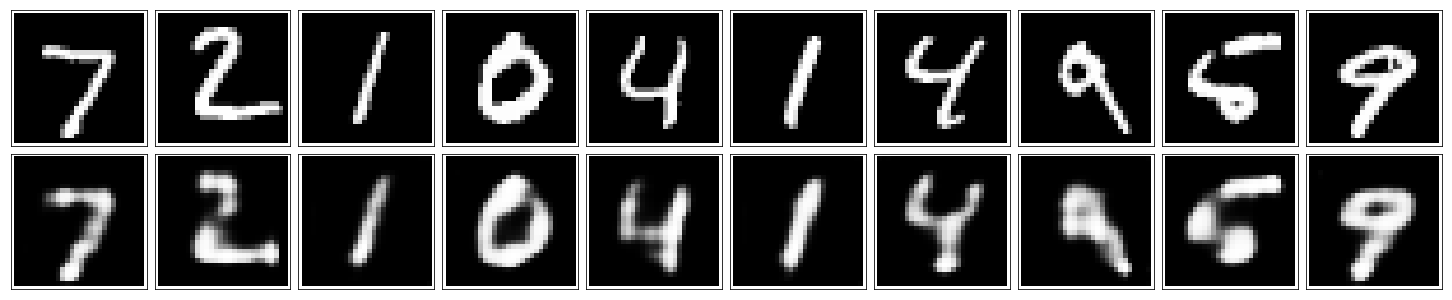

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [18]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [ ]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = 
# Now 28x28x32
maxpool1 = 
# Now 14x14x32
conv2 = 
# Now 14x14x32
maxpool2 = 
# Now 7x7x32
conv3 = 
# Now 7x7x16
encoded = 
# Now 4x4x16

### Decoder
upsample1 = 
# Now 7x7x16
conv4 = 
# Now 7x7x16
upsample2 = 
# Now 14x14x16
conv5 = 
# Now 14x14x32
upsample3 = 
# Now 28x28x32
conv6 = 
# Now 28x28x32

logits = 
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded =

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = 

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [ ]:
sess = tf.Session()

In [ ]:
epochs = 100
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)